# <span style="font-family: Arial, sans-serif; color:lightskyblue">Binary and Multiclass Modeling</span>
## Part 2: Gradient Boosting

<span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

References
---
* [Gradient Boosting Multi-Class Classification from Scratch](https://randomrealizations.com/posts/gradient-boosting-multi-class-classification-from-scratch/)
* [How does CatBoost perform multiclass classification?](https://stackoverflow.com/questions/77203295/how-does-catboost-perform-multiclass-classification)
* [How does XGBoost generate class probabilities in a multiclass classification problem?](https://github.com/dmlc/xgboost/issues/1746)

## Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = "is_bad"

# We assign a label of 2 to the records that almost never had delinquency and are bad
label = "label"
condition = (dataset["account_never_delinq_percent"] > 80) & (dataset[target] == 1)
dataset[label] = np.where(condition, 2, dataset[target])

X, y_binary, y_multi = dataset[features], dataset[target], dataset[label]

ix_train, ix_test = train_test_split(
    X.index, stratify=y_binary, test_size=0.3, random_state=62
)

## Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from rich.console import Console
from rich.table import Table
from rich import box


def display_classification_and_scores(
    y_true, preds, probas, prob_cols, class_labels, special_prob=None, model_name='model'
):
    console = Console()

    # Generate classification report
    class_report = classification_report(y_true, preds, output_dict=True)

    # Convert classification report to DataFrame for easier formatting
    class_report_df = pd.DataFrame(class_report).transpose()

    # Display classification report as a rich table with aesthetic colors
    console.print(f"[bold]Classification Report for {model_name}[/bold]\n")
    table = Table(show_header=True, header_style="bold cyan", box=box.SIMPLE)
    table.add_column("Class", justify="center", style="bold dodger_blue1")
    table.add_column("Precision", justify="right", style="bold cornflower_blue")
    table.add_column("Recall", justify="right", style="bold cornflower_blue")
    table.add_column("F1-score", justify="right", style="bold cornflower_blue")
    table.add_column("Support", justify="right", style="bold cornflower_blue")

    # Add rows for each class from the classification report
    for index, row in class_report_df.iterrows():
        table.add_row(
            f"{index}",
            f"{row['precision']:.2f}",
            f"{row['recall']:.2f}",
            f"{row['f1-score']:.2f}",
            f"{row['support']:.0f}",
        )

    console.print(table)

    # Prepare data for Gini and F1 scores
    # Create DataFrame with prob_0, prob_1, and prob_2
    df_with_preds = pd.DataFrame(probas, columns=prob_cols[: len(probas[0])])
    df_with_preds["label"] = y_true.values

    # Add the combined prob_1_and_2 if special_prob is provided
    if special_prob:
        df_with_preds[special_prob] = df_with_preds["prob_1"] + df_with_preds["prob_2"]

    # Prepare the one-hot encoded labels
    ohe_labels = pd.get_dummies(df_with_preds["label"])
    ohe_df = pd.DataFrame(ohe_labels.astype(int)).rename(
        columns={i: f"label_{i}" for i in class_labels}
    )

    # Add the combined label_1_and_2 if special_prob is provided
    if special_prob:
        ohe_df[special_prob] = ohe_df["label_1"] + ohe_df["label_2"]

    # Prepare pairs to rank
    pairs_to_rank = [(prob_cols[i], f"label_{i}") for i in range(len(class_labels))]

    # Add the special pair if present (e.g., prob_1_and_2)
    if special_prob:
        pairs_to_rank.append((special_prob, special_prob))

    # Calculate Gini and F1 scores
    ginis_and_f1 = {"p": [], "gini": [], "f1": []}
    for pair in pairs_to_rank:
        gini = 2 * roc_auc_score(ohe_df[pair[1]], df_with_preds[pair[0]]) - 1
        ginis_and_f1["p"].append(pair[0])
        ginis_and_f1["gini"].append(gini)
        f1_sc = f1_score(ohe_df[pair[1]], np.where(df_with_preds[pair[0]] > 0.5, 1, 0))
        ginis_and_f1["f1"].append(f1_sc)

    # Convert Gini and F1 scores to a DataFrame
    ginis_df = pd.DataFrame(ginis_and_f1)

    # Display Gini and F1 scores as a rich table with aesthetic colors
    console.print(f"\n[bold]Gini and F1 Scores for {model_name}[/bold]\n")
    gini_f1_table = Table(show_header=True, header_style="bold cyan", box=box.SIMPLE)
    gini_f1_table.add_column("Probability", justify="center", style="bold dodger_blue1")
    gini_f1_table.add_column("Gini Score", justify="right", style="bold purple")
    gini_f1_table.add_column("F1 Score", justify="right", style="bold chartreuse3")

    # Add rows to display Gini and F1 values with consistent color scheme
    for _, row in ginis_df.iterrows():
        gini_f1_table.add_row(row["p"], f"{row['gini']:.2f}", f"{row['f1']:.2f}")

    # Print the Gini and F1 scores table
    console.print(gini_f1_table)


def plot_calibration(y_true, y_pred, model_name, color):
    df = pd.DataFrame({
        'label': y_true,
        'prediction': y_pred
    })
    df = df.sort_values(by='prediction', ascending=True)
    df['cumulative_label'] = df['label'].cumsum() / df['label'].sum()
    ce = np.trapz(abs(df['cumulative_label'] - df['prediction']), df['cumulative_label'])
    plt.plot(df['cumulative_label'], df['prediction'], color=color, label=f"{model_name} CE: {ce:.2%}")

## Multiclass

### Linear models

In [3]:
import numpy as np
import pandas as pd
from fisher_scoring import FisherScoringLogisticRegression

# Initialize and fit the logistic regression model
model_binary = FisherScoringLogisticRegression(use_bias=True, information="expected", verbose=0)
model_binary.fit(X.loc[ix_train], y_binary.loc[ix_train])
probas_binary = model_binary.predict_proba(X.loc[ix_test])
preds_binary = model_binary.predict(X.loc[ix_test])

# Print summary
display_classification_and_scores(
    y_binary.loc[ix_test],
    preds_binary,
    probas_binary,
    ["prob_0", "prob_1"],
    [0, 1],
    model_name='Logistic Regression'
)

Classification Report for Logistic Regression

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.93     0.99       0.95      2700  
       1              0.68     0.29       0.40       300  
    accuracy          0.92     0.92       0.92         1  
   macro avg          0.80     0.64       0.68      3000  
  weighted avg        0.90     0.92       0.90      3000 

Gini and F1 Scores for Logistic Regression

 Probability   Gini Score   F1 Score  
 ───────────────────────────────────── 
    prob_0            0.79       0.95  
    prob_1            0.79       0.40 

In [4]:
import numpy as np
import pandas as pd
from fisher_scoring import FisherScoringMultinomialRegression

# Initialize and fit the multinomial model
model_multi = FisherScoringMultinomialRegression(use_bias=True, information="expected")
model_multi.fit(X.loc[ix_train], y_multi.loc[ix_train])
probas_multi = model_multi.predict_proba(X.loc[ix_test])
preds_multi = model_multi.predict(X.loc[ix_test])

# Print summary
display_classification_and_scores(
    y_multi.loc[ix_test],
    preds_multi,
    probas_multi,
    ["prob_0", "prob_1", "prob_2", "prob_1_and_2"],
    [0, 1, 2],
    special_prob="prob_1_and_2",
    model_name="Multinomial Regression"
)

Classification Report for Multinomial Regression

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.92     0.99       0.95      2700  
       1              0.65     0.38       0.48        81  
       2              0.55     0.13       0.21       219  
    accuracy          0.91     0.91       0.91         1  
   macro avg          0.70     0.50       0.55      3000  
  weighted avg        0.89     0.91       0.89      3000 

Gini and F1 Scores for Multinomial Regression

 Probability    Gini Score   F1 Score  
 ────────────────────────────────────── 
     prob_0            0.77       0.95  
     prob_1            0.95       0.45  
     prob_2            0.71       0.14  
  prob_1_and_2         0.77       0.39 

### XGBoost

In [5]:
import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

xgb_model_binary = xgb.XGBClassifier(
    max_depth=2,
    random_state=0,
)

xgb_model_binary.fit(X.loc[ix_train], y_binary.loc[ix_train])
probas_xgb_binary = xgb_model_binary.predict_proba(X.loc[ix_test])
preds_xgb_binary = xgb_model_binary.predict(X.loc[ix_test])

# Print summary
display_classification_and_scores(
    y_binary.loc[ix_test],
    preds_xgb_binary,
    probas_xgb_binary,
    ["prob_0", "prob_1"],
    [0, 1],
    model_name="XGBoost (binary)"
)

Classification Report for XGBoost (binary)

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.94     0.97       0.96      2700  
       1              0.66     0.45       0.53       300  
    accuracy          0.92     0.92       0.92         1  
   macro avg          0.80     0.71       0.75      3000  
  weighted avg        0.91     0.92       0.92      3000 

Gini and F1 Scores for XGBoost (binary)

 Probability   Gini Score   F1 Score  
 ───────────────────────────────────── 
    prob_0            0.88       0.96  
    prob_1            0.88       0.53 

In [6]:
import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

xgb_model_multi = xgb.XGBClassifier(
    objective="multi:softprob", num_class=3, max_depth=2
)

xgb_model_multi.fit(X.loc[ix_train], y_multi.loc[ix_train])
probas_xgb_multi = xgb_model_multi.predict_proba(X.loc[ix_test])
preds_xgb_multi = xgb_model_multi.predict(X.loc[ix_test])

display_classification_and_scores(
    y_multi.loc[ix_test],
    preds_xgb_multi,
    probas_xgb_multi,
    ["prob_0", "prob_1", "prob_2", "prob_1_and_2"],
    [0, 1, 2],
    special_prob="prob_1_and_2",
    model_name="XGBoost (multiclass)"
)

Classification Report for XGBoost (multiclass)

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.94     0.98       0.96      2700  
       1              0.70     0.62       0.66        81  
       2              0.67     0.42       0.51       219  
    accuracy          0.93     0.93       0.93         1  
   macro avg          0.77     0.67       0.71      3000  
  weighted avg        0.92     0.93       0.92      3000 

Gini and F1 Scores for XGBoost (multiclass)

 Probability    Gini Score   F1 Score  
 ────────────────────────────────────── 
     prob_0            0.88       0.96  
     prob_1            0.98       0.66  
     prob_2            0.90       0.51  
  prob_1_and_2         0.88       0.56 

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss
from matplotlib import pyplot as plt

df_with_preds_xgb_binary = pd.DataFrame({
    'prob_1': probas_xgb_binary[:, 1],
    'label': y_binary.loc[ix_test]
}).reset_index(drop=True)

df_with_preds_xgb_multi = pd.DataFrame({
    'prob_1_and_2': probas_xgb_multi[:, 1] + probas_xgb_multi[:, 2]
}).reset_index(drop=True)

joint_df = pd.concat(
    [
        df_with_preds_xgb_binary["prob_1"],
        df_with_preds_xgb_multi["prob_1_and_2"],
        df_with_preds_xgb_binary["label"],
    ],
    axis=1,
)

# Metrics
gini_binary = 2 * roc_auc_score(joint_df["label"], joint_df["prob_1"]) - 1
gini_multi = 2 * roc_auc_score(joint_df["label"], joint_df["prob_1_and_2"]) - 1
print(f"Gini score for binary: {gini_binary:.4f}")
print(f"Gini score for multi: {gini_multi:.4f}")

brier_binary = brier_score_loss(joint_df["label"], joint_df["prob_1"])
brier_multi = brier_score_loss(joint_df["label"], joint_df["prob_1_and_2"])
print(f"Brier score for binary: {brier_binary:.4f}")
print(f"Brier score for multi: {brier_multi:.4f}")

log_loss_binary = log_loss(joint_df["label"], joint_df["prob_1"])
log_loss_multi = log_loss(joint_df["label"], joint_df["prob_1_and_2"])
print(f"Log loss for binary: {log_loss_binary:.4f}")
print(f"Log loss for multi: {log_loss_multi:.4f}")

Gini score for binary: 0.8788
Gini score for multi: 0.8812
Brier score for binary: 0.0540
Brier score for multi: 0.0528
Log loss for binary: 0.1743
Log loss for multi: 0.1720


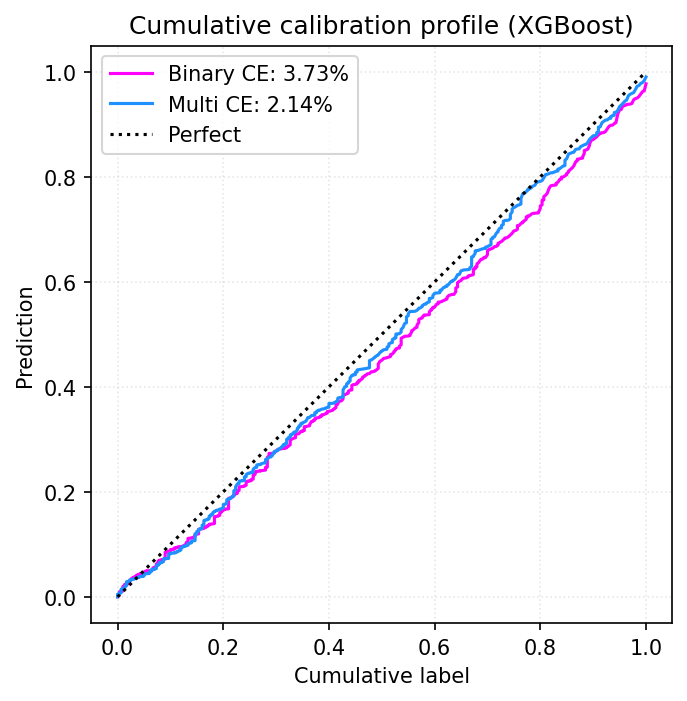

In [9]:
import matplotlib.pyplot as plt

# Initialize the plot
fig = plt.figure(figsize=(5, 5), dpi=150)
plot_calibration(joint_df["label"], joint_df["prob_1"], model_name='Binary', color="magenta")
plot_calibration(joint_df["label"], joint_df["prob_1_and_2"], model_name='Multi', color="dodgerblue")
plt.plot([0, 1], [0, 1], linestyle="dotted", label="Perfect", color="black")

# # Add labels and legend
plt.xlabel("Cumulative label")
plt.ylabel("Prediction")
plt.title("Cumulative calibration profile (XGBoost)")
plt.grid(alpha=0.3, linestyle="dotted")
plt.legend()
plt.show()

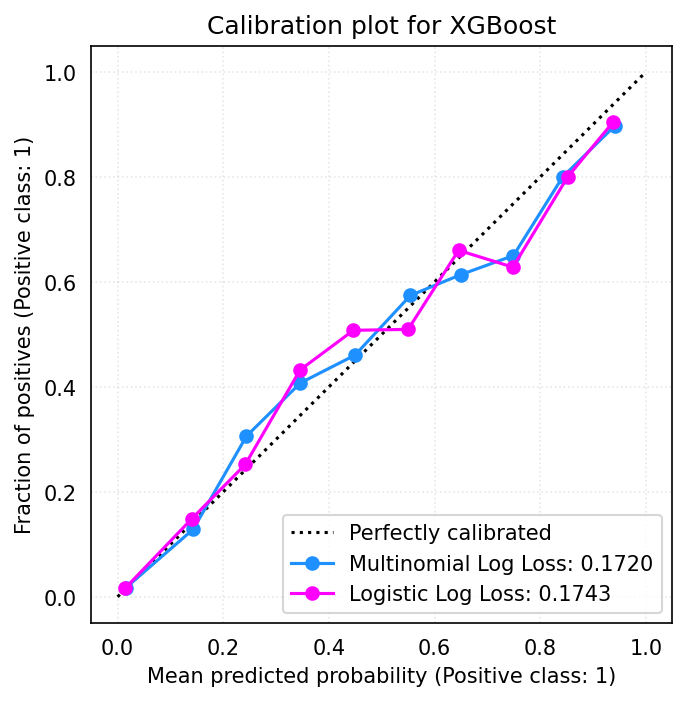

In [10]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

ax.set_title("Calibration plot for XGBoost")
calibration_multi = CalibrationDisplay.from_predictions(
    joint_df["label"],
    joint_df["prob_1_and_2"],
    label=f"Multinomial Log Loss: {log_loss_multi:.4f}",
    n_bins=10,
    color="dodgerblue",
    marker="o",
    ax=ax,
)

calibration_binary = CalibrationDisplay.from_predictions(
    joint_df["label"],
    joint_df["prob_1"],
    label=f"Logistic Log Loss: {log_loss_binary:.4f}",
    n_bins=10,
    color="magenta",
    marker="o",
    ax=ax,
)
ax.tick_params(width=0)
plt.grid(alpha=0.3, linestyle="dotted")
plt.show()

### CatBoost

In [11]:
import catboost as cb
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

cb_model_binary = cb.CatBoostClassifier(
    loss_function="Logloss",
    depth=2,
    verbose=0,
)

cb_model_binary.fit(X.loc[ix_train], y_binary.loc[ix_train])
probas_cb_binary = cb_model_binary.predict_proba(X.loc[ix_test])
preds_cb_binary = cb_model_binary.predict(X.loc[ix_test])

display_classification_and_scores(
    y_binary.loc[ix_test], 
    preds_cb_binary, 
    probas_cb_binary, 
    ["prob_0", "prob_1"], 
    [0, 1],
    model_name="CatBoost (binary)"
)

Classification Report for CatBoost (binary)

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.94     0.98       0.96      2700  
       1              0.67     0.41       0.51       300  
    accuracy          0.92     0.92       0.92         1  
   macro avg          0.80     0.70       0.73      3000  
  weighted avg        0.91     0.92       0.91      3000 

Gini and F1 Scores for CatBoost (binary)

 Probability   Gini Score   F1 Score  
 ───────────────────────────────────── 
    prob_0            0.88       0.96  
    prob_1            0.88       0.51 

In [12]:
import catboost as cb

cb_model_multi = cb.CatBoostClassifier(
    loss_function="MultiClass",
    depth=2,
    verbose=0,
)

cb_model_multi.fit(X.loc[ix_train], y_multi.loc[ix_train])
probas_cb_multi = cb_model_multi.predict_proba(X.loc[ix_test])
preds_cb_multi = cb_model_multi.predict(X.loc[ix_test])

display_classification_and_scores(
    y_multi.loc[ix_test],
    preds_cb_multi,
    probas_cb_multi,
    ["prob_0", "prob_1", "prob_2", "prob_1_and_2"],
    [0, 1, 2],
    special_prob="prob_1_and_2",
    model_name="CatBoost (multiclass)"
)

Classification Report for CatBoost (multiclass)

    Class       Precision   Recall   F1-score   Support  
 ──────────────────────────────────────────────────────── 
       0              0.94     0.98       0.96      2700  
       1              0.71     0.59       0.64        81  
       2              0.66     0.42       0.51       219  
    accuracy          0.92     0.92       0.92         1  
   macro avg          0.77     0.66       0.70      3000  
  weighted avg        0.92     0.92       0.92      3000 

Gini and F1 Scores for CatBoost (multiclass)

 Probability    Gini Score   F1 Score  
 ────────────────────────────────────── 
     prob_0            0.88       0.96  
     prob_1            0.98       0.65  
     prob_2            0.90       0.51  
  prob_1_and_2         0.88       0.55 

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss
from matplotlib import pyplot as plt

df_with_preds_cb_binary = pd.DataFrame({
    'prob_1': probas_cb_binary[:, 1],
    'label': y_binary.loc[ix_test]
}).reset_index(drop=True)

df_with_preds_cb_multi = pd.DataFrame({
    'prob_1_and_2': probas_cb_multi[:, 1] + probas_cb_multi[:, 2]
}).reset_index(drop=True)

joint_df = pd.concat(
    [
        df_with_preds_cb_binary["prob_1"],
        df_with_preds_cb_multi["prob_1_and_2"],
        df_with_preds_cb_binary["label"],
    ],
    axis=1,
)

# Metrics
gini_binary = 2 * roc_auc_score(joint_df["label"], joint_df["prob_1"]) - 1
gini_multi = 2 * roc_auc_score(joint_df["label"], joint_df["prob_1_and_2"]) - 1
print(f"Gini score for binary: {gini_binary:.4f}")
print(f"Gini score for multi: {gini_multi:.4f}")

brier_binary = brier_score_loss(joint_df["label"], joint_df["prob_1"])
brier_multi = brier_score_loss(joint_df["label"], joint_df["prob_1_and_2"])
print(f"Brier score for binary: {brier_binary:.4f}")
print(f"Brier score for multi: {brier_multi:.4f}")

log_loss_binary = log_loss(joint_df["label"], joint_df["prob_1"])
log_loss_multi = log_loss(joint_df["label"], joint_df["prob_1_and_2"])
print(f"Log loss for binary: {log_loss_binary:.4f}")
print(f"Log loss for multi: {log_loss_multi:.4f}")

Gini score for binary: 0.8800
Gini score for multi: 0.8849
Brier score for binary: 0.0538
Brier score for multi: 0.0527
Log loss for binary: 0.1738
Log loss for multi: 0.1708


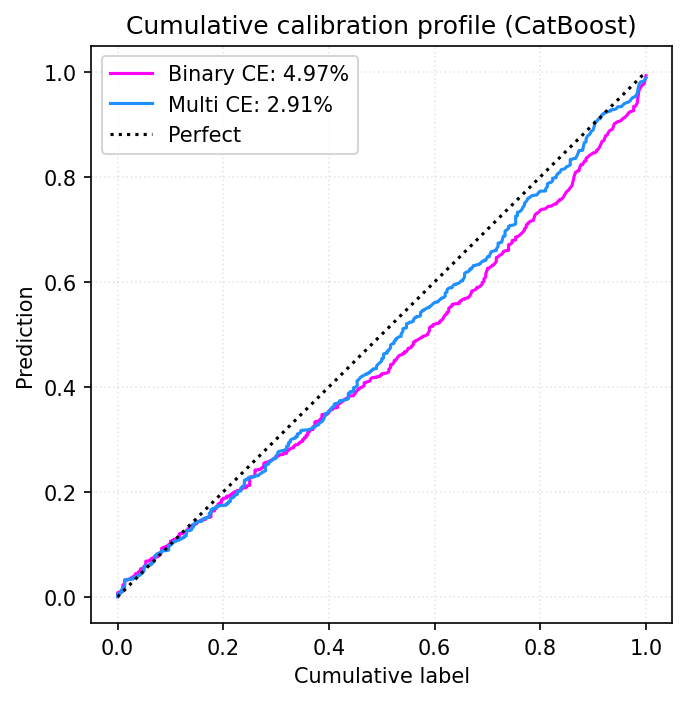

In [14]:
import matplotlib.pyplot as plt

# Initialize the plot
fig = plt.figure(figsize=(5, 5), dpi=150)
plot_calibration(joint_df["label"], joint_df["prob_1"], model_name='Binary', color="magenta")
plot_calibration(joint_df["label"], joint_df["prob_1_and_2"], model_name='Multi', color="dodgerblue")
plt.plot([0, 1], [0, 1], linestyle="dotted", label="Perfect", color="black")

# # Add labels and legend
plt.xlabel("Cumulative label")
plt.ylabel("Prediction")
plt.title("Cumulative calibration profile (CatBoost)")
plt.grid(alpha=0.3, linestyle="dotted")
plt.legend()
plt.show()

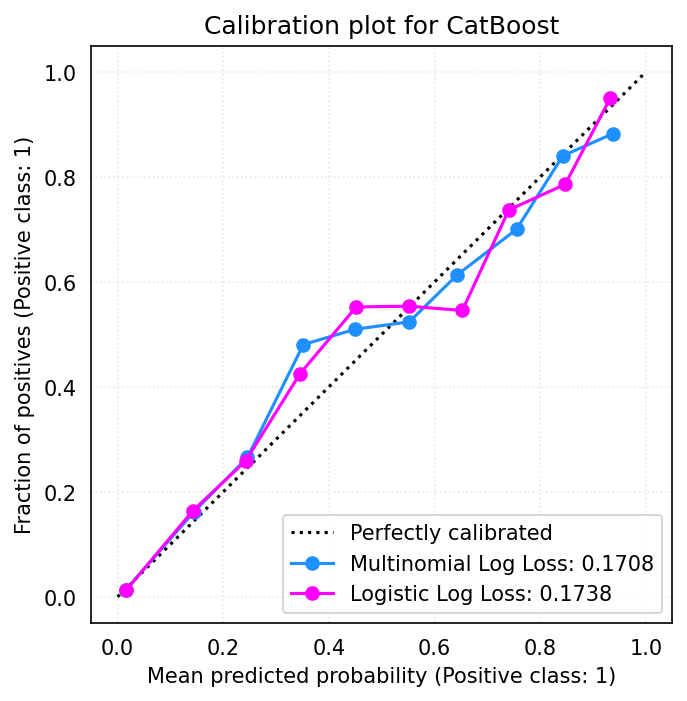

In [15]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

ax.set_title("Calibration plot for CatBoost")
calibration_multi = CalibrationDisplay.from_predictions(
    joint_df["label"],
    joint_df["prob_1_and_2"],
    label=f"Multinomial Log Loss: {log_loss_multi:.4f}",
    n_bins=10,
    color="dodgerblue",
    marker="o",
    ax=ax,
)

calibration_binary = CalibrationDisplay.from_predictions(
    joint_df["label"],
    joint_df["prob_1"],
    label=f"Logistic Log Loss: {log_loss_binary:.4f}",
    n_bins=10,
    color="magenta",
    marker="o",
    ax=ax,
)
plt.grid(alpha=0.3, linestyle="dotted")
ax.tick_params(width=0)
plt.show()